# Relprop and sensitivity from the web
http://heatmapping.org/tutorial/

In [30]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
#imports
import logging
import sys
logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import mdtraj as md
import numpy, copy, PIL, PIL.Image
import modules, utils
import matplotlib.pyplot as plt

class Network(modules.Network):
    def relprop(self, R):
        for l in self.layers[::-1]:
            R = l.relprop(R)
        return R


class ReLU(modules.ReLU):
    def relprop(self, R):
        return R


class NextLinear(modules.Linear):
    def relprop(self, R):
        V = numpy.maximum(0, self.W)
        Z = numpy.dot(self.X, V) + 1e-9
        S = R / Z
        C = numpy.dot(S, V.T)
        R = self.X * C
        return R


class FirstLinear(modules.Linear):
    def relprop(self, R):
        W, V, U = self.W, numpy.maximum(0, self.W), numpy.minimum(0, self.W)
        X, L, H = self.X, self.X * 0 + utils.lowest, self.X * 0 + utils.highest

        Z = numpy.dot(X, W) - numpy.dot(L, V) - numpy.dot(H, U) + 1e-9
        S = R / Z
        R = X * numpy.dot(S, W.T) - L * numpy.dot(S, V.T) - H * numpy.dot(
            S, U.T)
        return R
    
def visualize(x,colormap,name):

    N = len(x); assert(N<=16)

    x = colormap(x/numpy.abs(x).max())

    # Create a mosaic and upsample
    x = x.reshape([1,N,28,28,3])
    x = numpy.pad(x,((0,0),(0,0),(2,2),(2,2),(0,0)),'constant',constant_values=1)
    x = x.transpose([0,2,1,3,4]).reshape([1*32,N*32,3])
    x = numpy.kron(x,numpy.ones([2,2,1]))

    image = PIL.Image.fromarray((x*255).astype('byte'),'RGB')
    plt.figure(figsize=(16, 3))

    im = plt.imshow(image)
    plt.show()

# Sensitivity

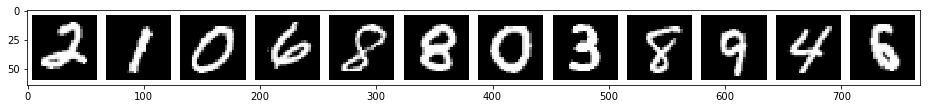

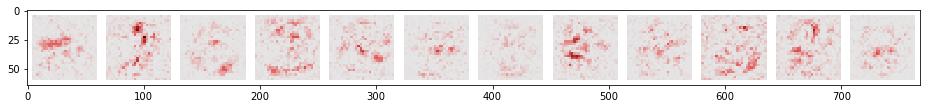

(12, 784) (12, 10)


In [38]:
nn = modules.Network([
    modules.Linear('mlp/l1'),
    modules.ReLU(),
    modules.Linear('mlp/l2'),
    modules.ReLU(),
    modules.Linear('mlp/l3'),
])

X,T = utils.getMNISTsample(N=12,path='mnist/',seed=1234)
visualize(X,utils.graymap,'data.png')
Y = nn.forward(X)
S = nn.gradprop(T)**2
visualize(S,utils.heatmap,'mlp-sensitivity.png')
print(X.shape, T.shape)


# Rel prop

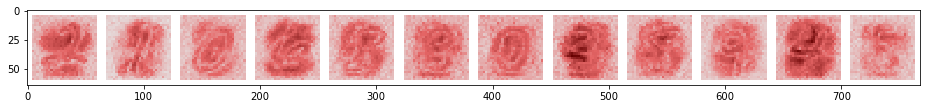

X shape (imagecount, pixelcount) =  (12, 784)
T shape (imagecount, number of classifier)= (12, 10)
T Non zero elements =  12
D shape (12, 784)
Weights  (784, 300)
bias  (300,)


In [72]:
nn = Network([
    FirstLinear('mlp/l1'),ReLU(),
    NextLinear('mlp/l2'),ReLU(),
    NextLinear('mlp/l3'),ReLU(),
])
Y = nn.forward(X)
D = nn.relprop(Y*T)
visualize(D,utils.heatmap,'mlp-deeptaylor.png')
print("X shape (imagecount, pixelcount) = ", X.shape)
print("T shape (imagecount, number of classifier)=", T.shape)
print("T Non zero elements = ", len(T[T != 0]))
print("D shape", D.shape)
first_layer = nn.layers[0]
print("Weights shape",first_layer.W.shape)
print("bias shape",first_layer.B.shape)